('Corrected gqrs detected peak indices:', [396, 711, 1032, 1368, 1712, 2036, 2349, 2661, 2972, 3301, 3630, 3960, 4283, 4609, 4928, 5240, 5568, 5898, 6222, 6527, 6830, 7142, 7462, 7785, 8105, 8413, 8721, 9025, 9320, 9628, 9999])


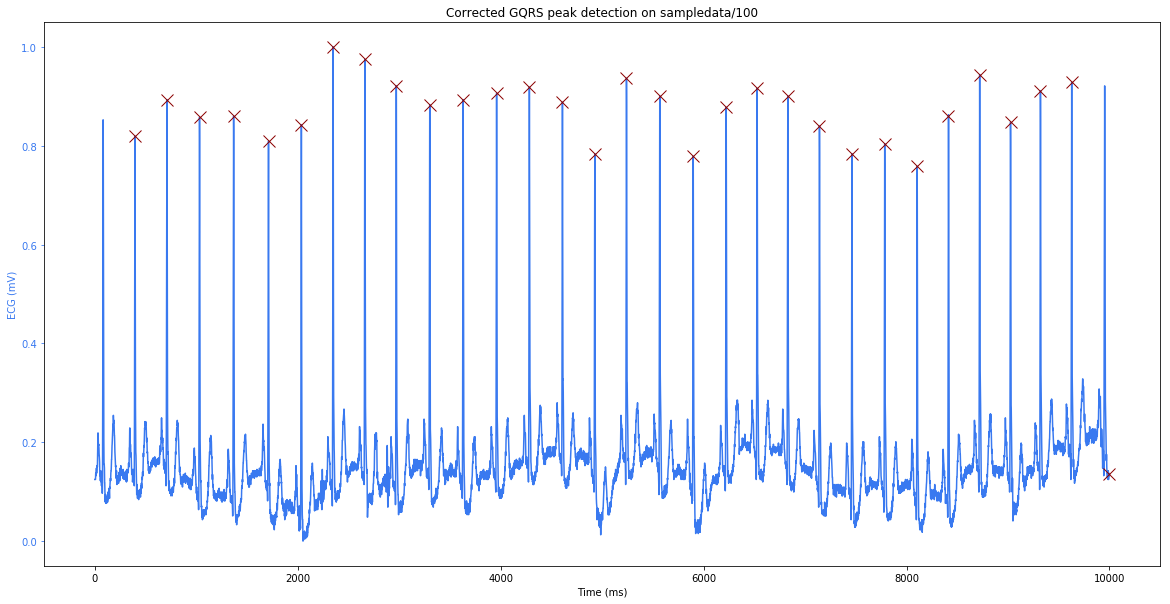

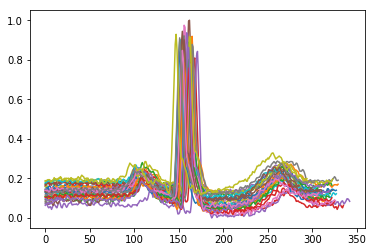

321


In [45]:
import caffe
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from itertools import tee, izip
import math

#heart rate calculation 
def peaks(x, peak_indices, fs, title, figsize=(20, 10), saveto=None):
    
    # Calculate heart rate
    hrs = wfdb.processing.compute_hr(siglen=x.shape[0], peak_indices=peak_indices, fs=fs)
    fig, ax_left = plt.subplots(figsize=figsize)
    
    ax_left.plot(x, color='#3979f0', label='Signal')
    ax_left.plot(peak_indices, x[peak_indices], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    
    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()
    return hrs

# Single beats extraction for record
def extract_beats(record,R_indices,peaks_hr):
    
    flat_record = [item for sublist in record for item in sublist]
    QRS_complexes = []
    
    for i in range(1, len(R_indices)-1):
        hr=peaks_hr[R_indices[i]].item()
        if(math.isnan(hr)):
            hr = 70
        samples_per_beat = int(freq*(60.0/hr))
        start = R_indices[i]-samples_per_beat/2;
        end = start + samples_per_beat;
        QRS_complexes.append(flat_record[start:end]);
    
    return QRS_complexes


#def gqrs_plot(recordname, t0=0, tf=30000):
t0=0
tf=10000
# Load the wfdb record and the physical samples
record = wfdb.rdsamp('C:/Users/Kareem/dl_dir/101', sampfrom=t0, sampto=tf, channels=[0])
sig = record.p_signals
sig = wfdb.processing.normalize(x=sig[:, 0], lb=0.0, ub=1.0)

for idx, val in enumerate(sig):
    record.p_signals[idx,0] = val

freq = record.fs 
# Use the gqrs algorithm to find peaks in the first channel
# The gqrs_detect argument expects a digital signal for the first argument.

d_signal = record.adc()[:,0]
peak_indices = wfdb.processing.gqrs_detect(d_signal, fs=freq, adcgain=record.adcgain[0], adczero=record.adczero[0], threshold=1.0)

# Correct the peaks by applying constraints
min_bpm = 20
max_bpm = 230
min_gap = record.fs*60/min_bpm
max_gap = record.fs*60/max_bpm
peak_indices = wfdb.processing.correct_peaks(d_signal, peak_indices=peak_indices, min_gap=min_gap, max_gap=max_gap, smooth_window=150)
sorted_peak_indices = sorted(peak_indices)
print('Corrected gqrs detected peak indices:', sorted_peak_indices)
peaks_hr = peaks(x=record.p_signals, peak_indices=sorted_peak_indices, fs=record.fs, title="Corrected GQRS peak detection on sampledata/100")
ecg_beats = extract_beats(record.p_signals,sorted_peak_indices,peaks_hr)

for i in range(0,len(ecg_beats)):
    plt.plot(ecg_beats[i])

plt.show()
print(len(ecg_beats[2]))